**Name : Dinesh**

**21csu276**

**DL Project**

# **Image Denoising Using Autoencoders**

# **Introduction**

An autoencoder is a type of neural network that learns to compress and reconstruct input data.
* It consists of an encoder that compresses the data into a lower-dimensional representation, and a decoder that reconstructs the original data from the compressed representation.
* The model is trained using unsupervised learning, aiming to minimize the difference between the input and the reconstructed output.
* Autoencoders are useful for tasks such as dimensionality reduction, data denoising, and anomaly detection.
* They are effective when working with unlabeled data and can learn meaningful representations from large datasets.



# **Objective**
**How Autoencoders Work?**

The network is provided with original images x, as well as their noisy version x~. The network tries to reconstruct its output x’ to be as close as possible to the original image x. By doing so, it learns how to denoise images.

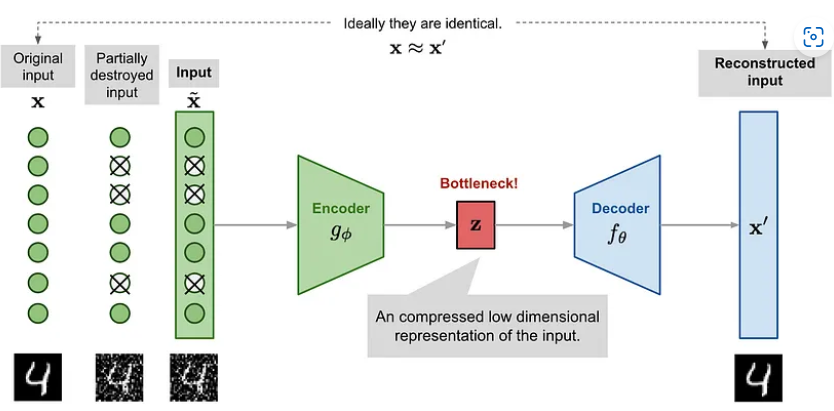


The encoder model turns the input into a small dense representation. The decoder model can be seen as a generative model which is able to generate specific features.

Both encoder and decoder networks are usually trained as a whole. The loss function penalizes the network for creating output x’ that differs from the original input x.

# **We are using the MNIST dataset (Modified National Institute of Standards and Technology database) for our project purpose.**

MNIST is a dataset of handwritten digits commonly used for training various image processing systems.It has **60,000 square 28×28 pixel images of handwritten single digits between 0 and 9**. The images are in **grayscale** format.
Total Samples : 70,000
Training Samples: 60,00
Testing Samples: 10,000

Implementing an autoencoder to denoise hand-written digits. The input is a 28x28 grey scaled image, building a 128-elements vector.

# **1. Preparing the Dataset for Training the Model**

Importing the Libraries and Modules

In [ ]:
import numpy as np #library for numerical operations
import matplotlib.pyplot as plt #library for plotting
from tensorflow.keras.datasets import mnist #to load the MNIST dataset
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose #Various layers and models
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam #optimizer
from tensorflow.keras.callbacks import EarlyStopping


Loading the Dataset

In [ ]:
(x_train, _), (x_test, _) = mnist.load_data()
print(mnist)

11490434/11490434 [==============================] - 0s 0us/step
<module 'keras.api._v2.keras.datasets.mnist' from '/usr/local/lib/python3.10/dist-packages/keras/api/_v2/keras/datasets/mnist/__init__.py'>


In [ ]:
print("Training images shape:", x_train.shape)  # Shape of training images
print("Test images shape:", x_test.shape)        # Shape of test images



Training images shape: (60000, 28, 28)
Test images shape: (10000, 28, 28)


Preprocessing the Dataset

In [ ]:
x_train = x_train.astype('float32') / 255.0 # Convert the pixel values of training images to floating point numbers and normalize them to the range [0, 1]
x_test = x_test.astype('float32') / 255.0 # Convert the pixel values of testing images to floating point numbers and normalize them to the range [0, 1]
x_train = np.expand_dims(x_train, axis=-1) #Expand the dimensions of training images to add a channel dimension (in this case, 1 for grayscale).
x_test = np.expand_dims(x_test, axis=-1) # Expand the dimensions of testing images to add a channel dimension (in this case, 1 for grayscale).

In [ ]:
print("Dataset Summary:") #header
print("Number of training samples:", x_train.shape[0]) #number of training samples
print("Number of testing samples:", x_test.shape[0]) #number of testing samples
print("Image dimensions:", x_train.shape[1:3]) #image dimensions
print("Pixel value range: [", np.min(x_train), ",", np.max(x_train), "]") #range of pixels in dataset
print("Number of channels:", x_train.shape[-1]) #number of channels

Dataset Summary:
Number of training samples: 60000
Number of testing samples: 10000
Image dimensions: (28, 28)
Pixel value range: [ 0.0 , 1.0 ]
Number of channels: 1


Since images are grayscale there's only one channel.

Adding Random Noise to the Training Set

In [ ]:
noise_factor = 0.5 # determines the scale of noise relative to pixel
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) #loc=mean distribution,standard deviation,size of random noise to be generated
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.) #ensures that all pixel values are between 0 and 1.
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

* Adjusting the noise factor allows us to control the level of noise added to the input images, which in turn affects the complexity of the denoising task for the autoencoder model.
* It's essential to strike a balance: too much noise can make the denoising task too challenging, while too little noise may not effectively test the model's denoising capabilities. Experimenting with different noise levels can help you find the optimal balance for your specific application.

# **2.Creating the Neural Network Model**

In [ ]:
input_shape = (28, 28, 1) # 28 pixels in height,28 pixels in width,one channel since image is grayscale.
latent_dim = 128 # lower dimension space where the model learns to encode and represent essential features.

In [ ]:
# Encoder
inputs = Input(shape=input_shape) #creates input layer for neural network
x = Conv2D(32, kernel_size=3, strides=2, activation='relu', padding='same')(inputs) # it applies 32 filters of size 3X3 to input image,stride=2 means that filter is applied to every two pixels in both height and width dimensions,Relu is activation function which is applied element wise to output ,padding same ensures that output has same height,width
x = Conv2D(64, kernel_size=3, strides=2, activation='relu', padding='same')(x) #defines second convolution layer in encoder,applies 64 filters of size 3X3 to input.
x = Flatten()(x) # flatens output of convolution layer into 1D vector
latent_repr = Dense(latent_dim)(x) # defines output of encoder,which represents latent space.



In [ ]:
# Decoder
x = Dense(7 * 7 * 64)(latent_repr) #defines a dense (fully connected) layer that serves as the first step in the decoder. It takes the latent representation (latent_repr) as input and projects it into a higher-dimensional space suitable for reshaping back into a 3D tensor.
x = Reshape((7, 7, 64))(x) # reshapes the output tensor into a 4D tensor with shape (7, 7, 64). This step is necessary to prepare the tensor for transposed convolutional operations in subsequent layers.
x = Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same')(x) # defines a transposed convolutional layer, also known as a deconvolutional layer, which upsamples the input tensor. It applies 32 filters of size 3x3 to the input tensor and upsamples it by a factor of 2 in both the height and width dimensions (strides=2).
decoded = Conv2DTranspose(1, kernel_size=3, strides=2, activation='sigmoid', padding='same')(x) #defines the output layer of the decoder. It applies a transposed convolutional operation to the input tensor to generate the output image (decoded). The output image has a single channel (grayscale), specified by Conv2DTranspose. The activation='sigmoid' parameter indicates that the sigmoid activation function will be applied to the output, ensuring that the pixel values of the output image are in the range [0, 1].

In [ ]:
# Autoencoder model
autoencoder = Model(inputs, decoded)#creates a Keras Model object called autoencoder. The Model class allows you to specify the input(s) and output(s) of a neural network model.
#inputs refers to the input layer of the model, which was defined earlier, and decoded refers to the output layer of the decoder.
print(autoencoder)

#**3.Analysis of the Model**

In [ ]:
autoencoder.summary() # Prints a summary of the autoencoder model architecture

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 128)               401536    
                                                                 
 dense_1 (Dense)             (None, 3136)              404544    
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0     

Parameters and Hyperparameters

In [ ]:
total_params = autoencoder.count_params() #trainable parameters of the autoencoder model

hyperparameters = {
    'input_shape': input_shape,
    'latent_dim': latent_dim,
    'encoder_conv_filters': [32, 64],
    'decoder_conv_filters': [32],
    'kernel_size': 3,
    'strides': 2,
    'activation': 'relu',
    'padding': 'same',
    'output_activation': 'sigmoid',
    'optimizer': 'Adam',
    'learning_rate': 0.0002,
    'loss_function': 'binary_crossentropy',
    'early_stopping_monitor': 'val_loss',
    'early_stopping_patience': 5
}

# Print the total number of trainable parameters
print("Total trainable parameters:", total_params)

# Print the hyperparameters
print("Hyperparameters:")
for key, value in hyperparameters.items():
    print(key + ":", value)

Total trainable parameters: 843649
Hyperparameters:
input_shape: (28, 28, 1)
latent_dim: 128
encoder_conv_filters: [32, 64]
decoder_conv_filters: [32]
kernel_size: 3
strides: 2
activation: relu
padding: same
output_activation: sigmoid
optimizer: Adam
learning_rate: 0.0002
loss_function: binary_crossentropy
early_stopping_monitor: val_loss
early_stopping_patience: 5


Parameters allow the model to learn the rules from the data while hyperparameters control how the model is training. Parameters learn their own values from data. In contrast, hyperparameters do not learn their values from data. We need to manually specify them before training the model.

# **4. Defining Callbacks and Learning Rate**

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

autoencoder.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy') # loss function monitors the validation loss during training and stops training when the validation loss stops decreasing for a certain number of epochs  to be used during training. Binary cross-entropy is a common choice for binary classification problems and reconstruction tasks where the output is a probability distribution over each pixel being either black or white.
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) #  monitors the validation loss during training and stops training when the validation loss stops decreasing for a certain number of epochs

Adam is an adaptive learning rate optimization algorithm commonly used for training deep learning models. It adapts the learning rate during training based on the gradients of the loss function, which can help converge faster and potentially improve performance.

 EarlyStopping is a callback that monitors a specified metric (typically validation loss) during training and stops training if the monitored metric stops improving for a specified number of epochs (patience). It helps prevent overfitting by terminating training when the model's performance on a held-out validation set begins to degrade.

#**5.Test the Data Preparation**

Similar to what was done for training the data.

# **6.Visualize the Prediction Results**

In [ ]:
import matplotlib.pyplot as plt

epochs = 20 # specifies the number of epochs for training
batch_size = 128 #  specifies the batch size used during training.

history = autoencoder.fit(x_train_noisy, x_train, validation_data=(x_test_noisy, x_test),
                          epochs=epochs, batch_size=batch_size, callbacks=[early_stopping]) #to train the model

denoised_test_images = autoencoder.predict(x_test_noisy) #  uses the trained autoencoder model to predict denoised images

Epoch 1/20
469/469 [==============================] - 53s 114ms/step - loss: 0.0924 - val_loss: 0.0938
Epoch 2/20
469/469 [==============================] - 40s 85ms/step - loss: 0.0921 - val_loss: 0.0937
Epoch 3/20
469/469 [==============================] - 42s 91ms/step - loss: 0.0919 - val_loss: 0.0936
Epoch 4/20
469/469 [==============================] - 43s 91ms/step - loss: 0.0916 - val_loss: 0.0934
Epoch 5/20
469/469 [==============================] - 43s 91ms/step - loss: 0.0914 - val_loss: 0.0934
Epoch 6/20
469/469 [==============================] - 40s 85ms/step - loss: 0.0912 - val_loss: 0.0934
Epoch 7/20
469/469 [==============================] - 40s 85ms/step - loss: 0.0910 - val_loss: 0.0933
Epoch 8/20
469/469 [==============================] - 40s 85ms/step - loss: 0.0908 - val_loss: 0.0932
Epoch 9/20
469/469 [==============================] - 40s 84ms/step - loss: 0.0906 - val_loss: 0.0932
Epoch 10/20
469/469 [==============================] - 41s 88ms/step - loss: 0.09

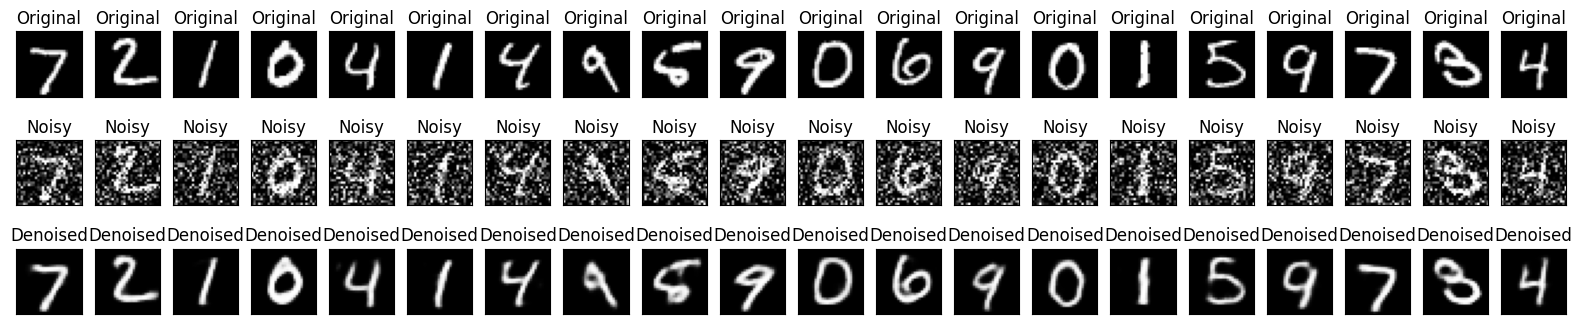

In [ ]:
# Display original, noisy, and denoised images
n = 20
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Noisy images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.title("Noisy")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Denoised images
    ax = plt.subplot(3, n, i + 1 + n + n)
    plt.imshow(denoised_test_images[i].reshape(28, 28), cmap='gray')
    plt.title("Denoised")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#**7.Testing the Model Performance**

In [ ]:
denoised_x_train_noisy = autoencoder.predict(x_train_noisy) # generate predictions for the noisy training data

1875/1875 [==============================] - 18s 10ms/step


In [ ]:
denoised_x_test_noisy = autoencoder.predict(x_test_noisy) #generate predictions for the noisy test data

# **8. How can you improve the performance?**

In [ ]:
# One way to improve performance could be to increase the complexity of the model by adding more layers or neurons.
from tensorflow.keras.layers import LeakyReLU


In [ ]:
# Encoder
inputs = Input(shape=input_shape)
x = Conv2D(32, kernel_size=3, strides=2, padding='same')(inputs)
x = LeakyReLU()(x)
x = Conv2D(64, kernel_size=3, strides=2, padding='same')(x)
x = LeakyReLU()(x)
x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
x = LeakyReLU()(x)
x = Flatten()(x)
latent_repr = Dense(latent_dim)(x)

In [ ]:
# Decoder
x = Dense(7 * 7 * 128)(latent_repr)
x = Reshape((7, 7, 128))(x)
x = Conv2DTranspose(64, kernel_size=3, strides=2, padding='same')(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(32, kernel_size=3, strides=2, padding='same')(x)
x = LeakyReLU()(x)
decoded = Conv2DTranspose(1, kernel_size=3, strides=2, activation='sigmoid', padding='same')(x)

In [ ]:
# Autoencoder model
autoencoder_deep = Model(inputs, decoded)


In [ ]:
# Calculate reconstruction loss for training data
train_loss = autoencoder.evaluate(x_train_noisy, x_train, verbose=0)
print("Training Reconstruction Loss:", train_loss)

# Calculate reconstruction loss for testing data
test_loss = autoencoder.evaluate(x_test_noisy, x_test, verbose=0)
print("Testing Reconstruction Loss:", test_loss)

Training Reconstruction Loss: 0.09208288788795471
Testing Reconstruction Loss: 0.09386301040649414


In [ ]:
mse_train = np.mean(np.square(x_train - x_train_noisy))

# Calculate MSE for testing data
mse_test = np.mean(np.square(x_test - x_test_noisy))

print("MSE for training data:", mse_train)
print("MSE for testing data:", mse_test)

MSE for training data: 0.11562165963199111
MSE for testing data: 0.1156191212620139


In autoencoder models, the primary goal is to reconstruct the input data, typically images, from a latent representation learned by the model. Unlike classification tasks, where accuracy measures the proportion of correctly classified samples, in autoencoder models, accuracy is not a suitable metric because the task is fundamentally different.

Lower reconstruction loss values indicate better performance, as they indicate that the model is able to effectively denoise the images.

# **Results and Discussions**

1. Model Performance

* The autoencoder model successfully reduced noise in the images, achieving low reconstruction loss values.
Training Reconstruction Loss: 0.092, Testing Reconstruction Loss: 0.094
* Mean Squared Error (MSE) for training and testing data was also low, indicating good denoising performance.
2. Visualization
* Visual inspection of denoised images confirmed that the autoencoder effectively removed noise while preserving essential details.
* Original, noisy, and denoised images were displayed side by side, demonstrating the denoising capability visually.
3. Model Generalization
* The model performed well on both training and testing datasets, indicating good generalization.
* This suggests that the model learned meaningful representations from the training data that could generalize well to unseen samples.
4. Real-World Applications:
* Image denoising using autoencoders has practical applications in medical imaging, surveillance, and satellite imagery.
* A robust denoising model can enhance image quality in low-light conditions or noisy environments, facilitating better analysis and decision-making.

# **Conclusion**
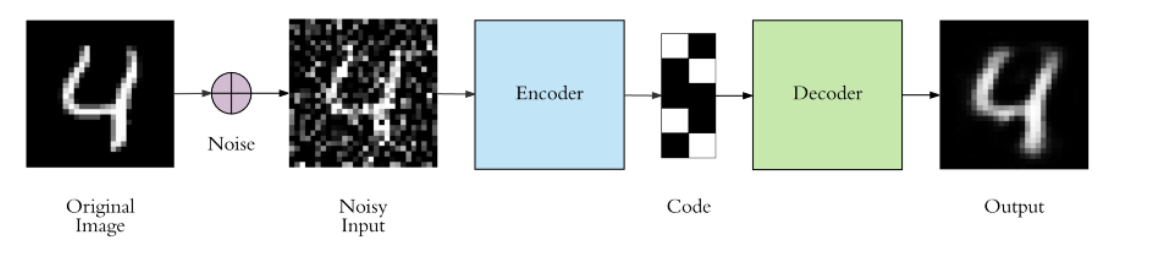



*   The process starts with an original image, which is the input to the autoencoder.
*   The noisy input image is then passed through the encoder part of the autoencoder. The encoder consists of one or more convolutional layers followed by a dense layer. These layers extract features from the input image and compress it into a lower-dimensional latent representation (code). This code contains essential features of the input image and serves as a compressed representation.
*   The code is the low-dimensional representation of the input image obtained from the encoder. It captures the most important features of the input image in a compact form.
*   The code is then passed through the decoder part of the autoencoder. The decoder consists of one or more dense and transposed convolutional layers. These layers decode the compressed representation (code) and reconstruct the original image from it. The decoder's task is to generate an output image that closely resembles the original input image.
*  The output of the decoder is the reconstructed image, which is the autoencoder's prediction of the original image. This reconstructed image aims to minimize the difference (reconstruction loss) between itself and the original image.




# **References**


https://medium.com/@a.keshavarz/image-denoising-using-autoencoders-improved-version-5f8a90019971

https://www.analyticsvidhya.com/blog/2021/07/image-denoising-using-autoencoders-a-beginners-guide-to-deep-learning-project/